In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import src.rainbow
import os
import glob
import pickle
import time


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Import the jsonified transactions into a dataframe

In [3]:
path = '/Users/Sarah/galvanize/dsi-capstone/data/jsons/2016'
all_files = glob.glob(os.path.join(path, "*.json"))

In [ ]:
path = '/Users/Sarah/galvanize/dsi-capstone/data/jsons/2018noaccount/'
all_files.append(glob.glob(os.path.join(path, "*.json")))

In [ ]:
all_files

In [4]:
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

In [4]:
for types in df.type.unique():
    print(types)    

Checkout


In [5]:
df=df[df['type']=='Checkout']

In [6]:
df.drop(columns='type',inplace=True)

In [7]:
print("terminals (registers):",df.term.unique())

terminals (registers): [ 8  7  3  9 12 10  5 11  6  4  2 13  1]


Drop transactions from register other than 1-9. Register 10 is the customer service desk returns register. Register 11 is the worker self checkout register.

In [8]:
df=df[df['term']<10]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862927 entries, 0 to 2427
Data columns (total 10 columns):
account    862927 non-null object
date       862927 non-null object
gross+     862927 non-null float64
gross-     862927 non-null float64
items      862927 non-null object
net        862927 non-null float64
oper       862927 non-null int64
term       862927 non-null int64
time       862927 non-null object
trans      862927 non-null int64
dtypes: float64(3), int64(3), object(4)
memory usage: 72.4+ MB


In [10]:
df.isna().sum()

account    0
date       0
gross+     0
gross-     0
items      0
net        0
oper       0
term       0
time       0
trans      0
dtype: int64

In [ ]:
df['account'].fillna([],inplace=True)

In [ ]:
df.info()

In [ ]:
df = pd.concat([df,df2], axis=0, ignore_index=True)

In [11]:
df['date']=pd.to_datetime(df['date'],yearfirst=True)

In [12]:
df['day_of_week']=df['date'].dt.day_name()
df['month']=df['date'].dt.month

In [59]:
df['hour']=pd.to_datetime(df['time']).dt.hour

In [13]:
pickle.dump(df,open('./data/pickles/df2016.p','wb'))

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import src.rainbow
import os
import glob
import pickle
import time


In [ ]:
df = pickle.load(open('./data/pickles/df2017.p','rb'))

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862927 entries, 0 to 2427
Data columns (total 15 columns):
account           862927 non-null object
date              862927 non-null datetime64[ns]
gross+            862927 non-null float64
gross-            862927 non-null float64
items             862927 non-null object
net               862927 non-null float64
oper              862927 non-null int64
term              862927 non-null int64
time              862927 non-null object
trans             862927 non-null int64
day_of_week       862927 non-null object
month             862927 non-null int64
total_of_items    862927 non-null int64
item_count        862927 non-null int64
hour              862927 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(7), object(4)
memory usage: 105.3+ MB


In [ ]:
df.drop(columns='type',inplace=True)

In [15]:
def get_items(df,most_common=10,least_common=5):
    df['total_of_items'] = 0
    stoppers = ['BAG CREDIT','SF Bag Charge','Gift Card Reload','8 OZ BIO TUB t3', '16OZ BIO TUB t4',
                 '32OZ BIO TUB t5','8 OZ PLSTC TUB t3','16 OZ PLSTC TUB t4','BOTTLE DEPOSIT','6PACK BEER SMALL C','PAID IN','Gift Card Sale',
                'PACKAGED FOOD', ]  
    '''build a dictionary where the keys are the words
    in the dataframe items column'''
    stopwords =[]
    items=[]
    item_dict = defaultdict(int)
    basket_counts=[]
    topics_list=[]
    
    for basket in df['items']:
        basket_counts.append(len(basket))
        for item in basket:
            
            items.append(item[1])
            item_dict[item[1]] += 1
    
    items_set=set(items)

    '''add the most common words to the stopwords list'''
    stopwords=list([i[0] for i in Counter(item_dict).most_common(most_common)])
    
    '''if topics_list exist, add these to stopwords to reveal next layer down'''
    if topics_list:
        for topics in topics_list:
            for i in topics:
                stopwords.append(i)
            
    '''add predetermined stoppers to stopwords list'''
    for s in stoppers:
        stopwords.append(s)
        
    '''add items containing "CRV" to the stopwords list'''
    for item in items_set:
        if "crv" in item.lower():
            stopwords.append(item)
    
    '''add the least common words to the stopwords list'''
    for key,value in item_dict.items():
        if value < least_common:
            stopwords.append(key)
    print(type(stopwords))
    #print(stopwords)
    stopwords_set = set(stopwords)
    
    '''iterate through the baskets and add items to items_set
    if not in stopwords (too common or too uncommon)'''
    for stops in stopwords_set:
        if stops in items_set:
            items_set.remove(stops)
  

    return items_set,stopwords_set, item_dict, basket_counts

items_set,stopwords,item_dict, basket_counts = get_items(df,most_common=5,least_common=15)

<class 'list'>


In [92]:
Counter(item_dict).most_common(50)

[('BAG CREDIT', 677709),
 ('SF Bag Charge', 197195),
 ('SMALL COOLER CRV', 154150),
 ('BANANAS', 133486),
 ('CRV SMALL NO TAX', 65535),
 ('CRV LRG SING NOTAX', 63394),
 ('8 OZ BIO TUB t3', 60556),
 ('CRV SMALL SING T', 52518),
 ('BOTTLE DEPOSIT', 48287),
 ('1lb STRAWBERRY', 46569),
 ('LEMONS', 43668),
 ('REFRIGERATED', 40703),
 ('16OZ BIO TUB t4', 39271),
 ('CRV LRG SING T', 38421),
 ('LARGE COOLER CRV', 37149),
 ('BAGEL', 35388),
 ('CELERY', 35160),
 ('GINGER', 31010),
 ('Worker 20% PkgFood', 29804),
 ('CILANTRO', 28682),
 ('CUCUMBERS', 28024),
 ('BEER SMALL CRV', 26445),
 ('PEACH', 25679),
 ('LIMES', 25583),
 ('CRV SML TAX NOEBT', 24300),
 ('Worker 20% Refrig', 21132),
 ('Worker 20% Produce', 19289),
 ('5290 WALNUTS', 19248),
 ('6PACK BEER SMALL C', 18685),
 ('PACKAGED FOOD', 18576),
 ('SATSUMA MANDARIN', 17594),
 ('4110 ORG ROLLED OA', 17261),
 ('BAKERY', 17034),
 ('SHALLOTS', 16820),
 ('TOMATO', 16601),
 ('GRAPEFRUIT', 16453),
 ('NECTARINE', 16210),
 ('CORN', 14914),
 ('5120 ORG AL

In [17]:
len(items_set)

24916

In [22]:
df.sample(10)

,account,date,gross+,gross-,items,net,oper,term,time,trans,day_of_week,month,total_of_items,item_count
2069,[[]],2016-09-21,1.79,0.00,"[[, CRV LRG SING NOTAX, 0.1, 15]]",1.79,49,7,18:38,280,Wednesday,9,0,1
102,[[8304]],2016-12-08,60.71,0.19,"[[, BIO WHOLE PLD TOM, 3.39, 15], [, BAG GRANN...",60.52,15,7,09:53,30,Thursday,12,0,15
71,[[3305]],2016-07-07,56.36,0.00,"[[, EGGS GLAUM XL, 5.99, 13], [, ORGANIC 2% MI...",56.36,98,7,09:45,18,Thursday,7,0,10
318,[[3367]],2016-09-24,80.44,0.00,"[[, BTN PNUT BUTR SAND, 4.39, 15], [, JR Q-Sor...",80.44,57,3,10:39,34,Saturday,9,0,15
2893,[[]],2016-04-10,119.68,0.00,"[[, BUILDER CHOC HAZ, 30.43, 15], [, REFRIGERA...",119.68,98,6,20:11,292,Sunday,4,0,19
1153,[[ 472]],2016-09-14,88.51,0.00,"[[, ORGANIC RAW MILK, 5.99, 13], [, FIUGGI STI...",88.51,62,6,14:48,204,Wednesday,9,0,19
3034,[[2883]],2016-02-28,64.87,0.00,"[[, 4105 QUICK OATS, 1.4, 16], [, T-Relief Gel...",64.87,58,7,21:08,281,Sunday,2,0,13
2169,[[7134]],2016-09-25,6.64,0.00,"[[, DEEB CHOCOLATE POP, 4.89, 19], [, LIVING H...",6.64,73,7,17:13,262,Sunday,9,0,2
2294,[[3204]],2016-10-19,27.64,0.00,"[[, BTN-HRVST WHT CRKR, 3.79, 15], [, BARE - A...",27.64,38,1,20:03,576,Wednesday,10,0,6
1357,[[3446]],2015-12-31,142.32,5.45,"[[, STRAWBERRIES, 11.99, 12], [, BLACKBERRIES,...",136.87,27,5,14:15,113,Thursday,12,0,28


In [19]:
df['item_count']=basket_counts

In [20]:
percentile = np.percentile(basket_counts, [25, 50, 75])
q1=percentile[0]
q2=percentile[1]
q3=percentile[2]

In [21]:
q1,q2,q3

(3.0, 7.0, 14.0)

In [ ]:
dfq1=df[(df['item_count']<=q1)]
dfq2=df[(df['item_count']>q1 )& (df['item_count']<=q2)]
dfq3=df[(df['item_count']>q2 )& (df['item_count']<=q3)]
dfq4=df[df['item_count']>q3]
df_avg=df[(df['item_count']>=10 )& (df['item_count']<=12)]

In [ ]:
df = df[df['item_count']>q2]

In [ ]:
df['item_count'].max()

In [60]:
df['hour'].describe()

count    862927.000000
mean         14.681150
std           3.229799
min           0.000000
25%          12.000000
50%          15.000000
75%          17.000000
max          23.000000
Name: hour, dtype: float64

In [61]:
df_day = df[(df['date']=='2016-01-02') & (df['item_count']>14)]
x= df_day['hour']
y= df_day['item_count']

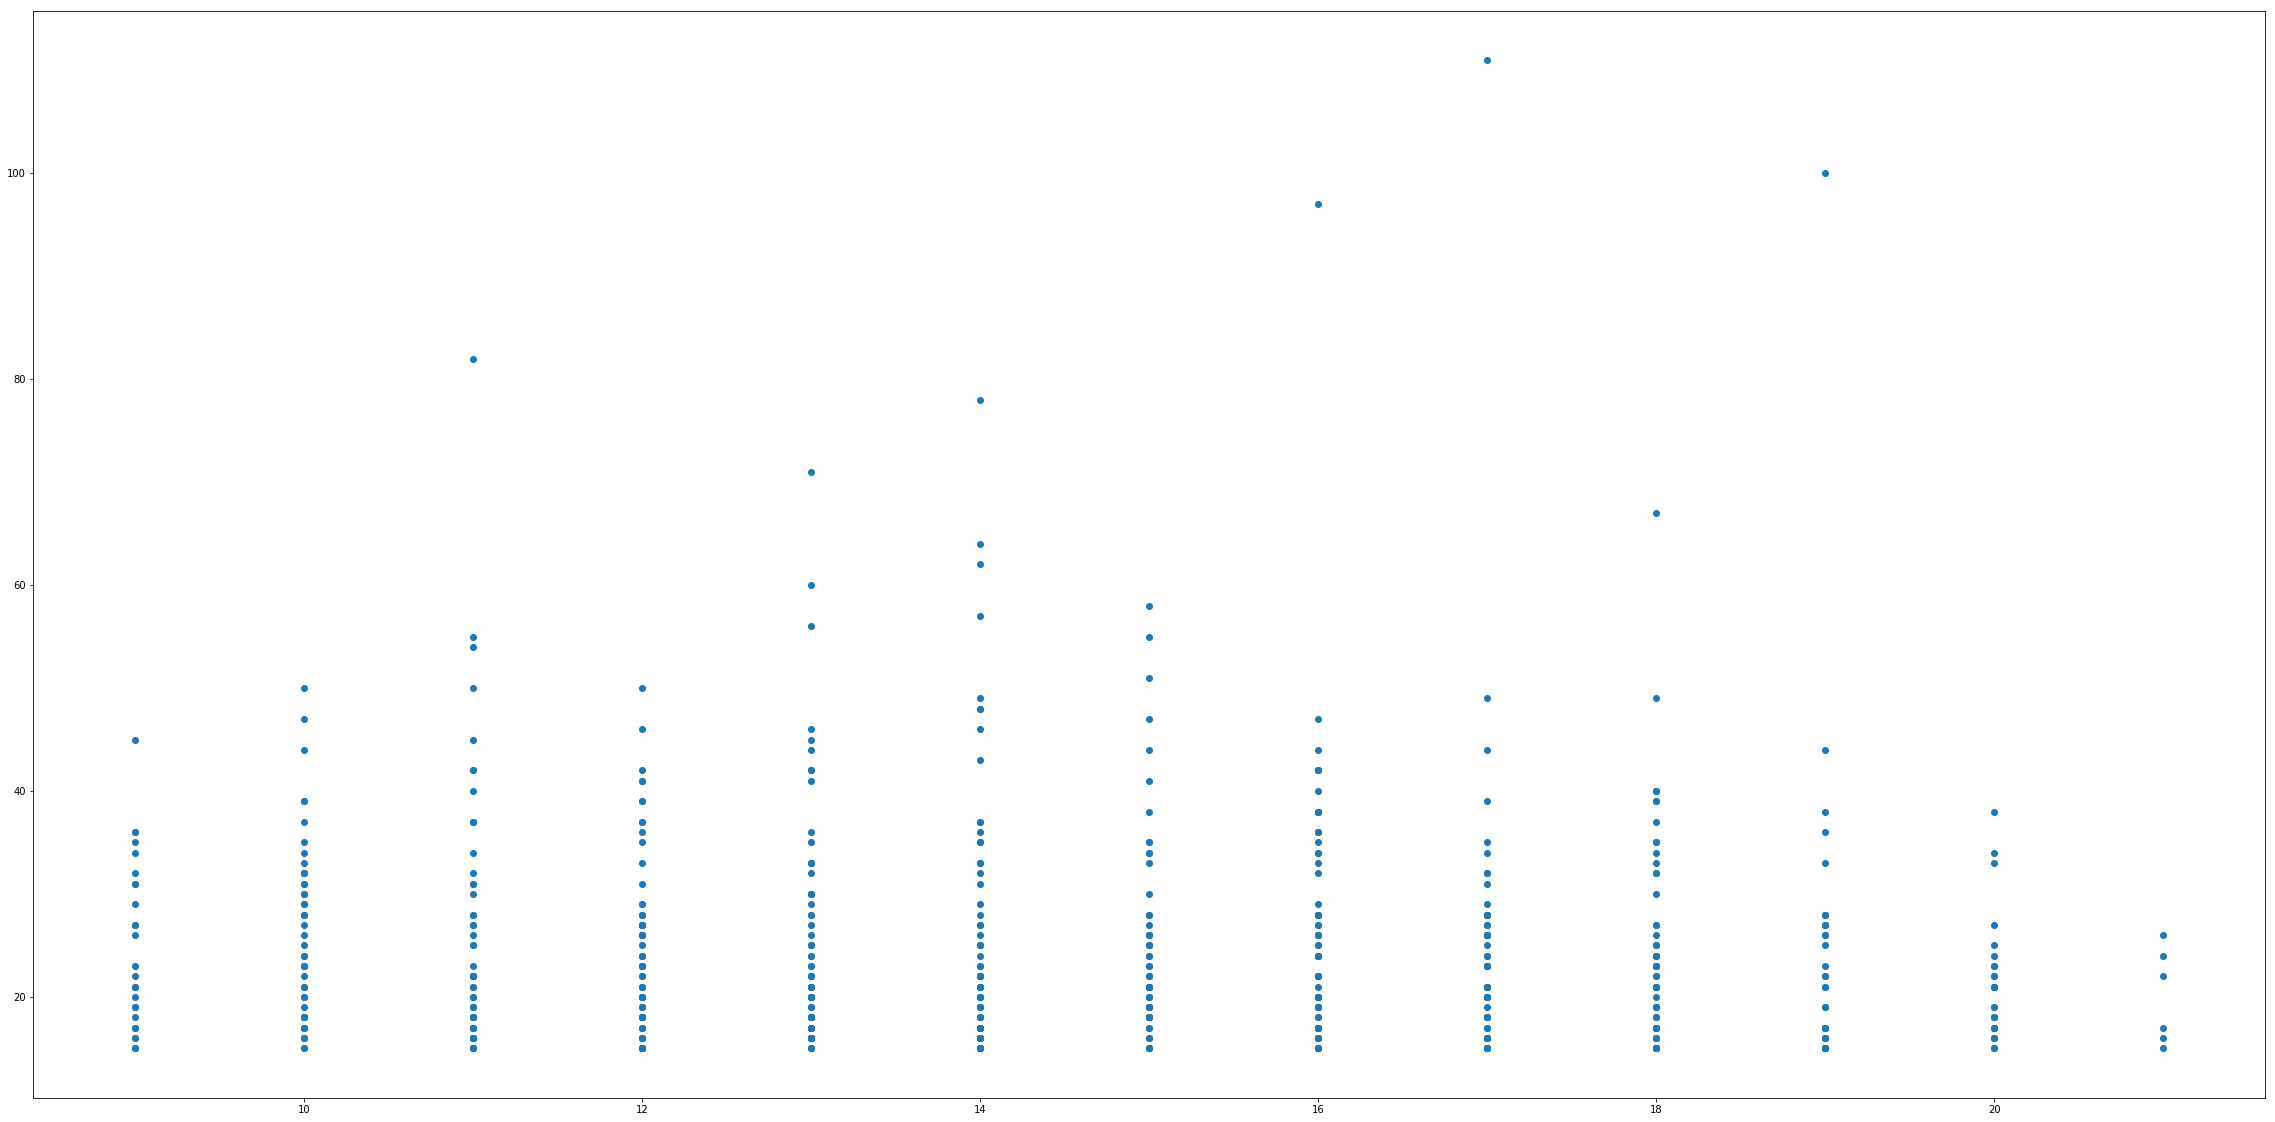

In [62]:
plt.figure(figsize=(40,20))
plt.scatter(x,y)

In [63]:
item_matrix = np.zeros((df.shape[0],len(items_set)))

In [64]:
df_items= pd.DataFrame(item_matrix,columns=items_set)

In [65]:
df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427],
           dtype='int64', length=862927)

In [66]:
df=df.reset_index()

In [67]:
df.index

RangeIndex(start=0, stop=862927, step=1)

In [68]:
df.describe()

,index,gross+,gross-,net,oper,term,trans,month,total_of_items,item_count,hour
count,862927.000000,862927.000000,862927.00000,862927.000000,862927.000000,862927.000000,862927.000000,862927.000000,862927.0,862927.000000,862927.000000
mean,1364.919710,60.702413,2.46987,58.273076,57.991766,4.803372,175.990354,6.622982,0.0,10.201341,14.681150
std,794.906105,212.303797,200.53094,68.144409,108.036963,2.458006,119.109663,3.413984,0.0,10.012444,3.229799
min,0.000000,0.000000,0.00000,-748.520000,1.000000,1.000000,1.000000,1.000000,0.0,0.000000,0.000000
25%,679.000000,15.310000,0.00000,15.030000,26.000000,3.000000,79.000000,4.000000,0.0,3.000000,12.000000
50%,1360.000000,37.630000,0.00000,37.040000,52.000000,5.000000,162.000000,7.000000,0.0,7.000000,15.000000
75%,2035.000000,78.200000,0.00000,76.820000,72.000000,7.000000,253.000000,10.000000,0.0,14.000000,17.000000
max,3452.000000,98771.150000,98710.30000,3414.640000,1745.000000,9.000000,699.000000,12.000000,0.0,205.000000,23.000000


In [69]:
df.pop('index')
print ()

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862927 entries, 0 to 862926
Data columns (total 15 columns):
account           862927 non-null object
date              862927 non-null datetime64[ns]
gross+            862927 non-null float64
gross-            862927 non-null float64
items             862927 non-null object
net               862927 non-null float64
oper              862927 non-null int64
term              862927 non-null int64
time              862927 non-null object
trans             862927 non-null int64
day_of_week       862927 non-null object
month             862927 non-null int64
total_of_items    862927 non-null int64
item_count        862927 non-null int64
hour              862927 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(7), object(4)
memory usage: 98.8+ MB


In [71]:
df.iloc[:,0].index


RangeIndex(start=0, stop=862927, step=1)

In [72]:
df_items.iloc[:,0].index

RangeIndex(start=0, stop=862927, step=1)

In [73]:
col_index_dict = dict(zip(items_set, range(len(items_set))))

In [74]:
col_index_dict['BANANAS']

KeyError: 'BANANAS'

In [ ]:
df.shape[0]

In [75]:
matrix_dict = defaultdict(int)
for i in range(df.shape[0]):
    for item in df['items'][i]:
        #set matrix to boolean for item precence in basket:
        #if item[1] not in stopwords and item[3] != 12:
        #if item[1] not in stopwords and item[3] not in (12,16):
        if item[1] not in stopwords:
            if item[2] > 0:
                value = 1
            elif item[2] == 0:
                value = 0
            else:
                value = -1
            matrix_dict[i,col_index_dict[item[1]]] += value

In [76]:
for item in items_set:
    if item.startswith('ONION'):
        print (item)

ONION GRUY CHZ RAV
ONION POWDER


In [77]:
len(matrix_dict)

6105681

In [78]:
for key,value in matrix_dict.items():
    print (key[0])
    print (key[1])
    print (value)
    break

0
7823
0


In [79]:
rows, cols, vals = [], [], []
for key, value in matrix_dict.items():
    rows.append(key[0])
    cols.append(key[1])
    vals.append(matrix_dict[key])
sparse_matrix = sparse.csr_matrix((vals, (rows, cols)))

In [ ]:
len(rows)

In [ ]:
import pickle

In [ ]:
sparse_matrix[4]

In [80]:
pickle.dump(sparse_matrix,open('./data/pickles/sparse_matrix2016.p','wb'))

In [81]:
pickle.dump(items_set,open('./data/pickles/items_set2016.p','wb'))

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import src.rainbow
import os
import glob
import pickle
import time


In [ ]:
file = open("./data/pickles/sparse_matrix2015.p",'rb')
sparse_matrix = pickle.load(file)
file.close()

In [ ]:
file = open("./data/pickles/items_set2015.p",'rb')
items_set = pickle.load(file)
file.close()

In [82]:
sparse_matrix = (sparse_matrix > 0).astype(int)

In [83]:
sum_of_zeros=sum(np.sum(sparse_matrix,axis=1)==0)
print(sum_of_zeros / sparse_matrix.shape[0],"% of zero weight baskets")

[[0.04405703]] % of zero weight baskets


In [84]:
number_of_components=6

In [85]:
def fit_NMF(sparse_matrix_,n_components_,max_iter=250):
    from sklearn.decomposition import NMF
    model = NMF(n_components=n_components_,max_iter=max_iter)
    W = model.fit_transform(sparse_matrix_)
    H=model.components_
    model_iter = model.n_iter_
    return model,W,H,model_iter
model,W,H,model_iter = fit_NMF(sparse_matrix,n_components_=number_of_components,max_iter=250)

In [86]:
print('iterations:',model_iter,'W shape:',W.shape,'H shape:',H.shape)

iterations: 85 W shape: (862927, 6) H shape: (6, 24916)


In [87]:
w = np.zeros_like(W)
w[np.arange(len(W)), W.argmax(1)] = 1
topic_strength = np.sum(w,axis=0)
topic_strength = np.round(topic_strength/topic_strength.sum(),2)
for i,t in enumerate(topic_strength):
    print('topic %d srength: %f '%(i,t))

topic 0 srength: 0.090000 
topic 1 srength: 0.100000 
topic 2 srength: 0.050000 
topic 3 srength: 0.110000 
topic 4 srength: 0.470000 
topic 5 srength: 0.180000 


In [88]:
'''from sklearn.decomposition import LatentDirichletAllocation as LDA
model = LDA(n_components=2,max_iter=10)
W = model.fit_transform(sparse_matrix)
H = model.components_
model.n_iter_'''

'from sklearn.decomposition import LatentDirichletAllocation as LDA\nmodel = LDA(n_components=2,max_iter=10)\nW = model.fit_transform(sparse_matrix)\nH = model.components_\nmodel.n_iter_'

In [89]:
feature_names=list(items_set).copy()
n_top_words=10
for topic in H:
    print(topic.argsort()[:-n_top_words -1:-1])
    print ([feature_names[i]for i in topic.argsort()[:-n_top_words -1:-1]])
    print()

[ 7049  3556 24611  3475  4344  8625  5684 14280  2130  9994]
['CELERY', 'CUCUMBERS', 'LEEKS', 'SATSUMA MANDARIN', 'FENNEL', '5290 WALNUTS', 'GRAPEFRUIT', 'BRUSSEL SPROUTS', 'COLLARDS', '5120 ORG ALMONDS']

[19622   644 22141  9834  5497  5157 16035  3556 13424  2184]
['1lb STRAWBERRY', 'PEACH', 'NECTARINE', 'BLUEBERRIES', 'TOMATO', 'CORN', 'MINI SEEDLESS H20', 'CUCUMBERS', 'APRICOT/APRIUM', 'BLACKBERRIES']

[ 6836  8257  2705  3556   644  5684 22141  5497 23213  4344]
['LEMONS', 'LIMES', 'SHALLOTS', 'CUCUMBERS', 'PEACH', 'GRAPEFRUIT', 'NECTARINE', 'TOMATO', 'PARMIGIANO REGG', 'FENNEL']

[ 1589  3910   644     9 22092  8625  9834 22141  3475 20417]
['REFRIGERATED', 'BAKERY', 'PEACH', 'BULK', 'PRODUCE', '5290 WALNUTS', 'BLUEBERRIES', 'NECTARINE', 'SATSUMA MANDARIN', 'SUNDRIES']

[20203  5501  8257  2705  8625 13563  9994  3475  5684 24611]
['GINGER', 'CILANTRO', 'LIMES', 'SHALLOTS', '5290 WALNUTS', '4110 ORG ROLLED OA', '5120 ORG ALMONDS', 'SATSUMA MANDARIN', 'GRAPEFRUIT', 'LEEKS']

[13

In [90]:
pickle.dump(sparse_matrix,open('./data/pickles/topics_list2017.p','wb'))

0.09 Topic #0 of 6:
['CELERY', 'CUCUMBERS', 'LEEKS', 'SATSUMA MANDARIN', 'FENNEL', '5290 WALNUTS', 'GRAPEFRUIT', 'BRUSSEL SPROUTS', 'COLLARDS', '5120 ORG ALMONDS']


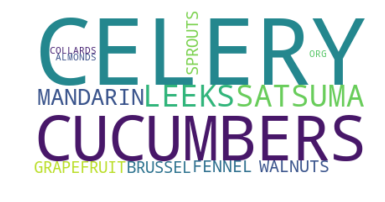

<img src="./img/2018/1554499467.topic0.png">
0.1 Topic #1 of 6:
['1lb STRAWBERRY', 'PEACH', 'NECTARINE', 'BLUEBERRIES', 'TOMATO', 'CORN', 'MINI SEEDLESS H20', 'CUCUMBERS', 'APRICOT/APRIUM', 'BLACKBERRIES']


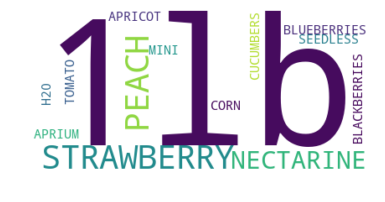

<img src="./img/2018/1554499468.topic1.png">
0.05 Topic #2 of 6:
['LEMONS', 'LIMES', 'SHALLOTS', 'CUCUMBERS', 'PEACH', 'GRAPEFRUIT', 'NECTARINE', 'TOMATO', 'PARMIGIANO REGG', 'FENNEL']


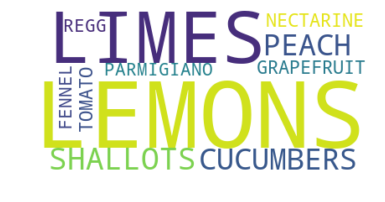

<img src="./img/2018/1554499468.topic2.png">
0.11 Topic #3 of 6:
['REFRIGERATED', 'BAKERY', 'PEACH', 'BULK', 'PRODUCE', '5290 WALNUTS', 'BLUEBERRIES', 'NECTARINE', 'SATSUMA MANDARIN', 'SUNDRIES']


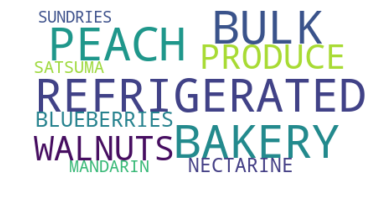

<img src="./img/2018/1554499469.topic3.png">
0.47 Topic #4 of 6:
['GINGER', 'CILANTRO', 'LIMES', 'SHALLOTS', '5290 WALNUTS', '4110 ORG ROLLED OA', '5120 ORG ALMONDS', 'SATSUMA MANDARIN', 'GRAPEFRUIT', 'LEEKS']


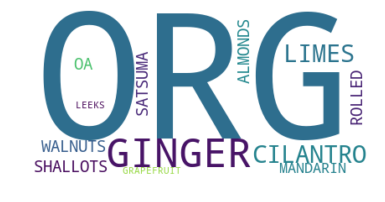

<img src="./img/2018/1554499469.topic4.png">
0.18 Topic #5 of 6:
['BAGEL', 'SATSUMA MANDARIN', '4110 ORG ROLLED OA', 'BAKERY', 'OV CRM CHEESE SPRE', '5290 WALNUTS', 'EGGS DZ ROCK LG', 'WHOLE ORG MILK', 'TOMATO', 'GINA MARIE CC']


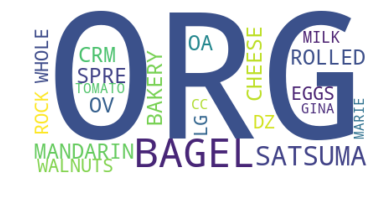

<img src="./img/2018/1554499470.topic5.png">
[['CELERY', 'CUCUMBERS', 'LEEKS', 'SATSUMA MANDARIN', 'FENNEL', '5290 WALNUTS', 'GRAPEFRUIT', 'BRUSSEL SPROUTS', 'COLLARDS', '5120 ORG ALMONDS'], ['1lb STRAWBERRY', 'PEACH', 'NECTARINE', 'BLUEBERRIES', 'TOMATO', 'CORN', 'MINI SEEDLESS H20', 'CUCUMBERS', 'APRICOT/APRIUM', 'BLACKBERRIES'], ['LEMONS', 'LIMES', 'SHALLOTS', 'CUCUMBERS', 'PEACH', 'GRAPEFRUIT', 'NECTARINE', 'TOMATO', 'PARMIGIANO REGG', 'FENNEL'], ['REFRIGERATED', 'BAKERY', 'PEACH', 'BULK', 'PRODUCE', '5290 WALNUTS', 'BLUEBERRIES', 'NECTARINE', 'SATSUMA MANDARIN', 'SUNDRIES'], ['GINGER', 'CILANTRO', 'LIMES', 'SHALLOTS', '5290 WALNUTS', '4110 ORG ROLLED OA', '5120 ORG ALMONDS', 'SATSUMA MANDARIN', 'GRAPEFRUIT', 'LEEKS'], ['BAGEL', 'SATSUMA MANDARIN', '4110 ORG ROLLED OA', 'BAKERY', 'OV CRM CHEESE SPRE', '5290 WALNUTS', 'EGGS DZ ROCK LG', 'WHOLE ORG MILK', 'TOMATO', 'GINA MARIE CC']]


In [93]:
def print_top_items(model, feature_names, n_top_words):
    topic_dict = defaultdict()
    topics_list =[]
    fig = plt.figure()
    for topic_idx, topic in enumerate(model.components_):
        print(topic_strength[topic_idx],"Topic #%d of %d:" %( topic_idx,number_of_components))
        #topic_string=(" ".join([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]))
        topic_string=[feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict[topic_idx]=topic_string
        topics_list.append(topic_string)
        print(topic_string)
        #print()
        #wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(str(topic_string).replace(" ", "_").replace("'",""))
        wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(str(topic_string).replace("'","").replace(",",""))
        ax = fig.add_subplot(2,1,topic_idx+1)
        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        img_time=str(time.time()).split('.')[0]
        wordcloud.to_file('./img/2018/%s.topic%d.png'%(img_time,topic_idx))
        print('<img src="./img/2018/%s.topic%d.png">'%(img_time,topic_idx))
    return topic_dict,topics_list

topic_dict,topics_list = print_top_items(model,list(items_set),n_top_words)
print(topics_list)

In [144]:
topics3=topic_dict.copy()

In [145]:
topic_compare = np.zeros([len(topic_dict),len(topic_dict)])

for topic in topic_dict:
    for item in topic_dict[topic]:
        for topic2 in topic_dict:
            if item in topic_dict[topic2]:
                topic_compare[topic,topic2]+=1
print (topic_strength)            
print(topic_compare)


[0.14 0.05 0.54 0.05 0.17 0.04]
[[10.  0.  0.  1.  0.  4.]
 [ 0. 10.  3.  5.  5.  0.]
 [ 0.  3. 10.  2.  2.  0.]
 [ 1.  5.  2. 10.  3.  0.]
 [ 0.  5.  2.  3. 10.  0.]
 [ 4.  0.  0.  0.  0. 10.]]


In [146]:
list_of_topics=[]
for topic in topic_dict:
     list_of_topics.append(topic_dict[topic])

In [147]:
topic_matrix=np.array(topics_list).T
topic_matrix.shape

(10, 6)

In [151]:
pd.DataFrame(topic_matrix,columns=topic_strength).to_pickle('./data/pickles/2017topics%d.pkl'%number_of_components)

In [152]:
topic_df = pd.DataFrame(topic_matrix,columns=topic_strength)

In [153]:
import tabulate 


In [154]:
print(tabulate.tabulate(topic_df.values,topic_df.columns, tablefmt="pipe")) 

| 0.14             | 0.05               | 0.54               | 0.05             | 0.17          | 0.04               |
|:-----------------|:-------------------|:-------------------|:-----------------|:--------------|:-------------------|
| ONIONS YELLOW    | LEMONS             | 1lb STRAWBERRY     | CELERY           | CILANTRO      | AVOCADOS HASS      |
| GARLIC WHITE     | LIMES              | REFRIGERATED       | CUCUMBERS        | GINGER        | TOMATO MIX HEIRLOO |
| APPLES FUJI      | SHALLOTS           | PEACH              | CARROTS LOOSE    | LIMES         | APPLES FUJI        |
| PEPPERS RED BELL | GRAPEFRUIT         | BAGEL              | LEEKS            | SHALLOTS      | TOMATO DRY FARM    |
| CARROTS LOOSE    | CUCUMBERS          | NECTARINE          | 5290 WALNUTS     | PEPPER CHILI  | SPINACH LOOSE      |
| SQUASH ZUCCHINI  | CUKE MEDIT/PERSIAN | 5290 WALNUTS       | GRAPEFRUIT       | CUCUMBERS     | PEPPERS RED BELL   |
| ONIONS RED       | 5290 WALNUTS       | CUCUMB

In [ ]:
ingredients =np.array((len(topics),len(topics[0])))
for row in topics:
    print('row',row)
    for i,item in enumerate(topics[row]):
        if item not in topics[row]:
            print ('i',i,item)
            
        if item not in topics[0]:
            print ('iI',i,item)
        #ingredients[row:i]=item
ingredients

In [ ]:
len(ing_set)

In [ ]:
ing_index_dict = dict(zip(ing_set, range(len(ing_set))))

In [ ]:
ingredients=np.array(ingredients)
ingredients=ingredients.reshape(5,55)

In [ ]:
ingredients.shape

In [ ]:
ing_matrix=np.zeros(ingredients.shape)

In [ ]:
for row,col in enumerate(ingredients):
    for i,c in enumerate(col):
        #print(row,i,c)
        ing_matrix[row,i]=ing_index_dict[c]
ing_matrix

In [ ]:
ing_array=ing_index_dict.values()

ing_array

In [ ]:
for i in ing_matrix:
    print(ing_array==i)

In [ ]:
for ing_index_dict

In [ ]:
def print_basket_contents(basket_id):
    basket=[]
    #print('+++++++++++++++++++++++next basket+++++++++++++++++')
    for items in df['items'][basket_id]:
        #for item in items:
        print("item:",items)
    #return basket
#print_basket_contents(1116)

In [ ]:
def print_top_baskets(model, W, n_top_words):
    baskets = []
    for topic_idx, w in enumerate(W.T):
        basket_string=str([df['items'][i] for i in w.argsort()[:-n_top_words - 1:-1]])
        count = 0
        for i in w.argsort()[:-n_top_words - 1:-1]:
            count+=1
            print("++++++++++++++++++Topic #%d, basket #%d+++++++++++++++++++"%(topic_idx,count))
            print_basket_contents(i)
        #print_basket_contents([i for i in w.argsort()[:-n_top_words - 1:-1]])
        baskets.append(basket_string)
        #print(basket_string)
        #print()
        '''wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(basket_string.replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('topic%d.png'%topic_idx)'''
print_top_baskets(model,W,10)

In [ ]:
df['item_count'].max()

In [ ]:
W[:,1]

In [ ]:
n_top_words=10
for i,w in enumerate(W.T):
    print(i,w.argsort()[:-n_top_words - 1:-1])

In [ ]:
len(list(items_set))

In [ ]:
for topic in H:
    print (topic.argsort()[:-10-1:-1])

In [ ]:
feat
str([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])

In [ ]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            print (it[1],it[2])

In [ ]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

In [ ]:
df['CILANTRO'][10:11]

In [ ]:
df.shape[0]
for i in range(1,df.shape[0]):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

In [ ]:
df.shape

In [ ]:
df.to_pickle('02012019.pkl')

In [ ]:
len(items_set)

In [ ]:
trans = []
for a in df[1:2]['items']:
    #trans.append([r for v in a for r in v])
    trans.append(a)
print(a)

In [ ]:
trans =[]
for l in [i for i in df[1:2]['items']]:
    print (l)
    trans.append(l)
    print (trans)

In [ ]:
#pd.get_dummies([i for i in df[1:2]['items']]).values()

In [ ]:

type(df['items'].values)
count=0
for document in df['items'][1]:
    print (document)
    
    for word in(document):
        count+=1
        print (count,word)
        '''for letter in str(word):
            print (letter)'''

In [ ]:
df[['gross+','time']].plot()
plt.show()

In [ ]:
ff= './tlogs/201902'
if ff.startswith("./tlogs"):
    print ("yep")

In [ ]:
for f in os.walk('./tlogs'): print ("f:",f,"sub:",sub)


In [ ]:
import os

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file

        if filepath.endswith(".asm"):
            print (filepath)

In [ ]:
df=pd.read_pickle('02012019.pkl')

In [ ]:
df[df['BANANAS']!=0]

In [ ]:
df.columns

In [ ]:
plt.scatter(x=df['time'],y=df['gross+'])

In [ ]:
df.type='Va'

In [ ]:
def get_dataframe(filepath):

    all_files = glob.glob(os.path.join(filepath, "*.json"))
    df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 
    df=df[df['term']<10]
    df['date']=pd.to_datetime(df['date'],yearfirst=True)
    df['day_of_week']=df['date'].dt.day_name()
    df['month']=df['date'].dt.month
    return df

In [ ]:
path = '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/'
df = get_dataframe(path)

In [ ]:
all_files =[]
for f in range(0,366):
    all_files.append(path+"%d.json"%f)
print (all_files)

In [ ]:
import pandas as pd 
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

In [ ]:
df.info()

In [ ]:
plt.scatter(dfq1['item_count'],dfq1['term'])